In [1]:
!pip install pandas numpy seaborn matplotlib lifetimes scikit-learn yellowbrick -q


In [2]:
#import libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
#READ THE FILE
bank = pd.read_csv("../output/EDA_bank_data.csv")

# RFM ANALYSIS

In [4]:
bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Age,AgeGroup
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,143207,25.0,31.0,Middle
1,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,142712,459.0,28.0,Young
2,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,142714,2060.0,51.0,Senior
3,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-08-02,181156,1762.5,37.0,Middle
4,T6,C1536588,1972-10-08,F,ITANAGAR,53609.20,2016-08-02,173940,676.0,52.0,Senior


In [5]:
# Convert TransactionDate to datetime format
bank['TransactionDate'] = pd.to_datetime(bank['TransactionDate'])

# Set reference date
reference_date = bank['TransactionDate'].max()

# Group data by CustomerID to compute RFM
rfm = bank.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (reference_date - x.max()).days,  # Recency: days since last transaction
    'TransactionID': 'count',  # Frequency: number of transactions
    'TransactionAmount (INR)': 'sum'  # Monetary: total spent
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print(rfm.head())

  CustomerID  Recency  Frequency  Monetary
0   C1010011       25          2    5106.0
1   C1010012       68          1    1499.0
2   C1010014       75          2    1455.0
3   C1010018       36          1      30.0
4   C1010028       53          1     557.0


In [6]:
rfm.shape

(799010, 4)

In [7]:
rfm[['Recency', 'Frequency', 'Monetary']].corr()

,Recency,Frequency,Monetary
Recency,1.000000,-0.212688,-0.016695
Frequency,-0.212688,1.000000,0.090027
Monetary,-0.016695,0.090027,1.000000


In [8]:
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])

In [9]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score
0,C1010011,25,2,5106.0,4
1,C1010012,68,1,1499.0,2
2,C1010014,75,2,1455.0,1
3,C1010018,36,1,30.0,4
4,C1010028,53,1,557.0,3


(150000.0, 222722.85)

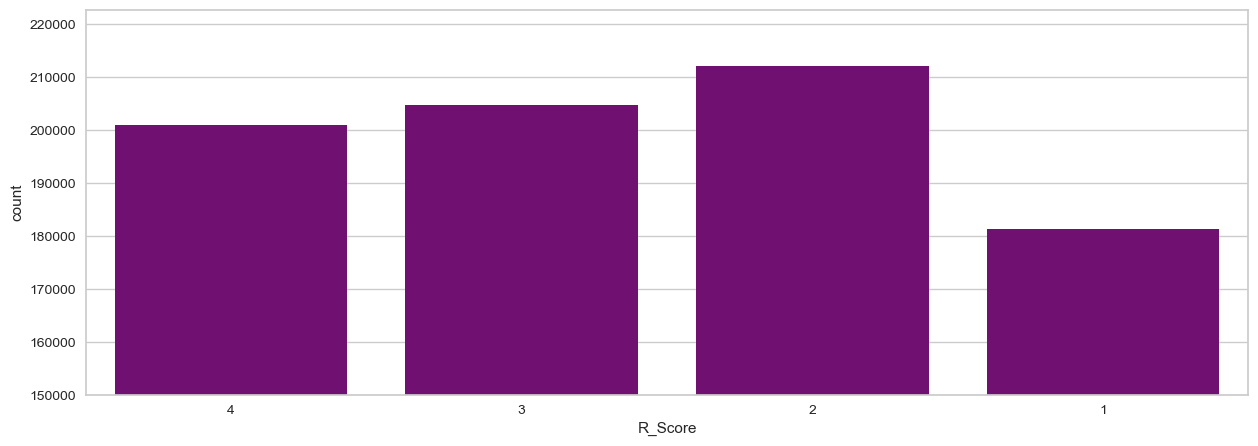

In [37]:
#Visualize the distribution along the RFM_Score

plt.figure(figsize = (15, 5))
sns.countplot(x = rfm["R_Score"], color="purple")
plt.ylim(150000)


# Recency Score Distribution

R_Score 2, with approximately 211,000 customers: these are moderately recent customers.

R_Score 3 has about 204,000 customers: second largest segment, these are your most recent customers.

R_Score 4 with roughly 201,000 customers: These customers haven't purchased recently.

R_Score 1 has the lowest value at approximately 181,000 customers: These represent customers with below-average recency.

In [11]:
# Custom bins based on inspection
rfm['F_Score'] = pd.cut(rfm['Frequency'],
                        bins=[0, 1, 2, 4, rfm['Frequency'].max()],
                        labels=[1, 2, 3, 4],
                        include_lowest=True)

In [12]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score
0,C1010011,25,2,5106.0,4,2
1,C1010012,68,1,1499.0,2,1
2,C1010014,75,2,1455.0,1,2
3,C1010018,36,1,30.0,4,1
4,C1010028,53,1,557.0,3,1


<Axes: xlabel='F_Score', ylabel='count'>

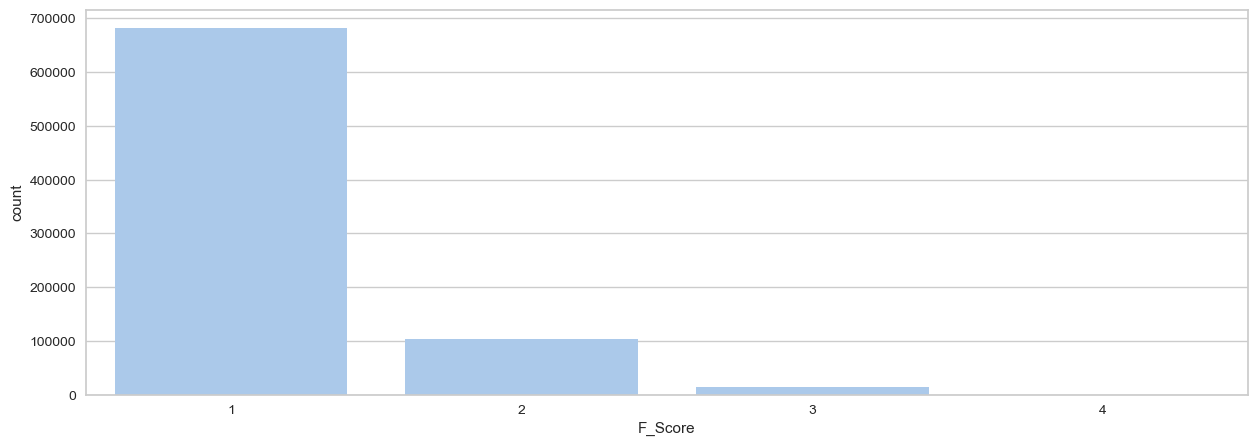

In [40]:
#Visualize the distribution along the RFM_Score

plt.figure(figsize = (15, 5))
sns.countplot(x = rfm["F_Score"])


Bin 1: One-time customers.

Bin 2: Low repeaters (2 txns).

Bin 3: Moderate (3–4 txns).

Bin 4: High frequency (5+ txns).

In [14]:
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4], duplicates='drop')

In [15]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,C1010011,25,2,5106.0,4,2,4
1,C1010012,68,1,1499.0,2,1,4
2,C1010014,75,2,1455.0,1,2,4
3,C1010018,36,1,30.0,4,1,1
4,C1010028,53,1,557.0,3,1,3


(150000.0, 223288.8)

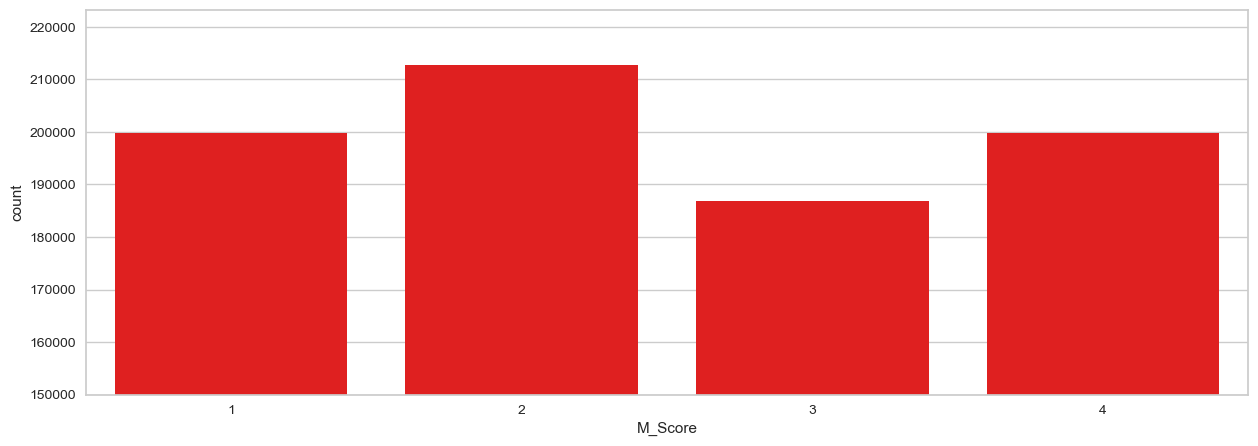

In [42]:
#Visualize the distribution along the RFM_Score

plt.figure(figsize = (15, 5))
sns.countplot(x = rfm["M_Score"], color="red")
plt.ylim(150000)


## Monetary Score Distribution
The histogram shows the distribution of M_Score (Monetary Value Score) across your customer base:

Score 2 (Highest count, about 210,000 customers): These are low-spending customers.

Score 1 (Lowest count, about 200,000 customers): This segment has the fewest customers, representing moderate-low spenders.

Score 4 ( about 200,000 customers): These customers represent moderate-high spenders.

Score 3 (about 187,000 customers): These are likely your highest-value customers in terms of spending.

# 🧮 RFM Scoring

In [17]:
rfm['RFM_Segment'] = (
    rfm['R_Score'].astype(str) + 
    rfm['F_Score'].astype(str) + 
    rfm['M_Score'].astype(str)
)

rfm['RFM_Score'] = (
    rfm[['R_Score', 'F_Score', 'M_Score']]
    .astype(int)
    .sum(axis=1)
)

In [18]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,C1010011,25,2,5106.0,4,2,4,424,10
1,C1010012,68,1,1499.0,2,1,4,214,7
2,C1010014,75,2,1455.0,1,2,4,124,7
3,C1010018,36,1,30.0,4,1,1,411,6
4,C1010028,53,1,557.0,3,1,3,313,7


<Axes: xlabel='RFM_Score', ylabel='count'>

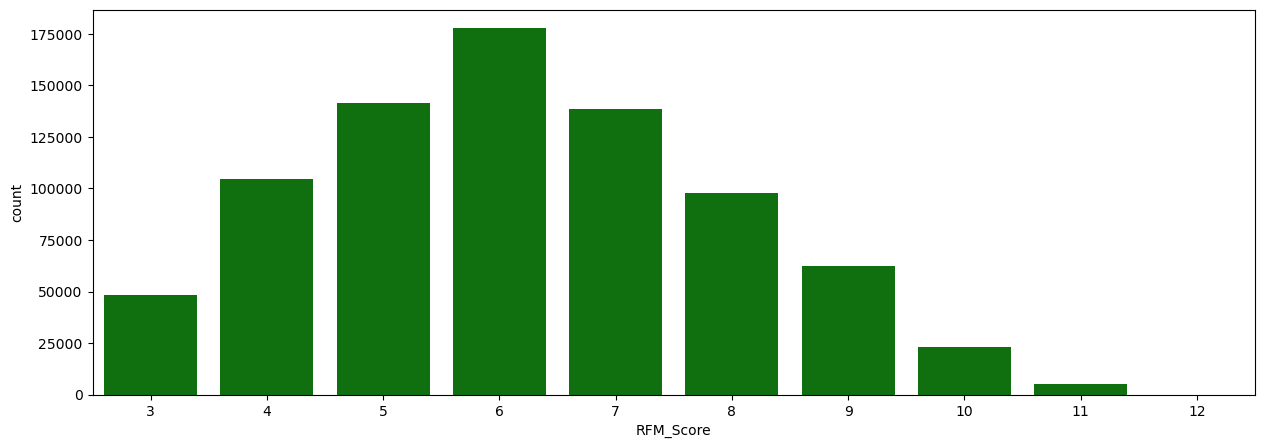

In [19]:
#Visualize the distribution along the RFM_Score

plt.figure(figsize = (15, 5))
sns.countplot(x = rfm["RFM_Score"], color ="green")


#  Segment Mapping

In [20]:
def assign_segment(score):
    if score >= 9:
        return 'Best Customers'
    elif score >= 6:
        return 'Loyal Customers'
    elif score >= 4:
        return 'At Risk'
    else:
        return 'Churned'

rfm['Segment'] = rfm['RFM_Score'].apply(assign_segment)

In [21]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
0,C1010011,25,2,5106.0,4,2,4,424,10,Best Customers
1,C1010012,68,1,1499.0,2,1,4,214,7,Loyal Customers
2,C1010014,75,2,1455.0,1,2,4,124,7,Loyal Customers
3,C1010018,36,1,30.0,4,1,1,411,6,Loyal Customers
4,C1010028,53,1,557.0,3,1,3,313,7,Loyal Customers


<Axes: xlabel='Segment', ylabel='count'>

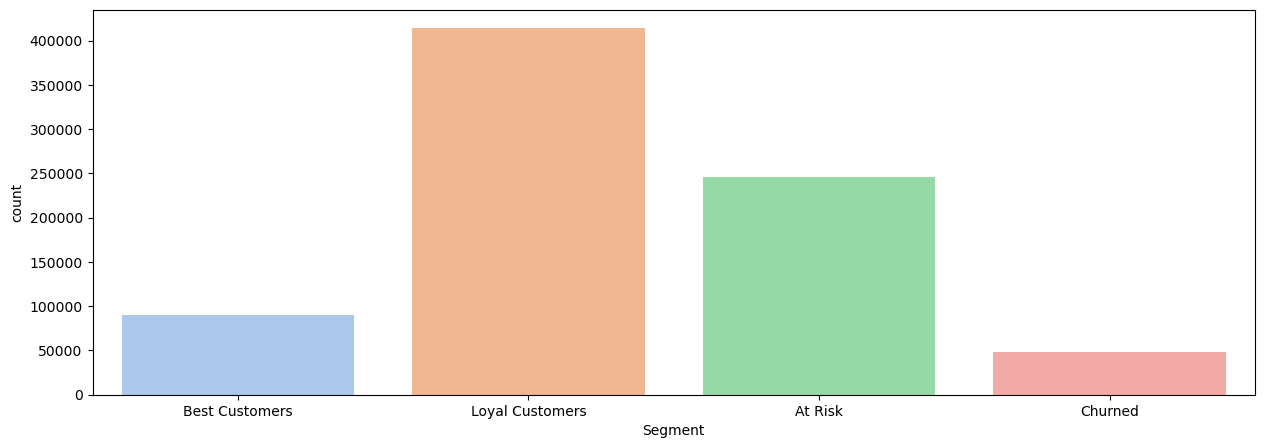

In [22]:
#Visualize the distribution along the RFM_Score

plt.figure(figsize = (15, 5))
sns.set_palette("pastel")
sns.countplot(x = rfm["Segment"],hue=rfm['Segment'])



# Key Takeaways
- Best Customers (~100,000): These are high-value customers with frequent transactions.
- Loyal Customers (~450,000): A strong base that consistently engages.
- At Risk (~250,000): These customers show signs of decreasing engagement.
- Churned (~50,000): Customers who have likely stopped transacting altogether.

# Possible Actions
- Retention Efforts: Focus on At Risk customers with personalized incentives.
- Reactivation Strategies: Target Churned customers with special promotions.
- Loyalty Programs: Strengthen engagement with Loyal and Best Customers.



In [23]:
rfm_feat = rfm[['Recency', 'Frequency', 'Monetary']]

In [24]:
from sklearn.preprocessing import StandardScaler

# Standardize Recency, Frequency, Monetary
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_feat)

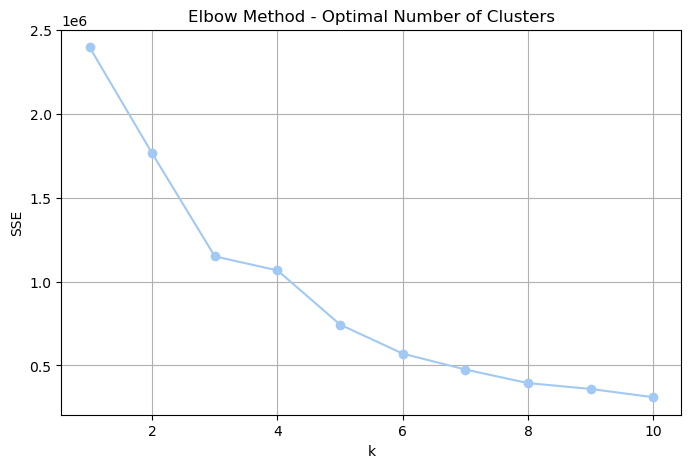

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    sse.append(model.inertia_)

# Plot SSE to find elbow
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.title("Elbow Method - Optimal Number of Clusters")
plt.xlabel("k")
plt.ylabel("SSE")
plt.grid(True)
plt.show()

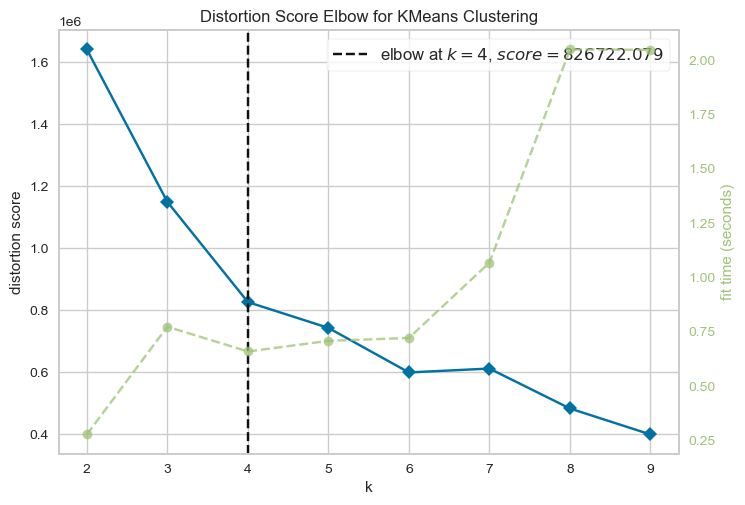

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA

kmeans = KMeans()
#applying the elbow visualizer to find optimal k
visualizer = KElbowVisualizer(kmeans, k=(2, 10), metric='distortion', timing=False)

visualizer.fit(rfm_scaled)  #fitting the scaled data
visualizer.show() 

# K-MEANS METHOD

In [27]:
# Fit model with chosen number of clusters (4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [28]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).reset_index()

print(cluster_summary)

   Cluster    Recency  Frequency     Monetary   Count
0        0  53.624517   1.000000  1165.214488  226479
1        1  72.038086   1.000000  1331.306275  275876
2        2  47.708311   2.121536  3452.883994  117118
3        3  37.474615   1.000000  1257.720828  179537


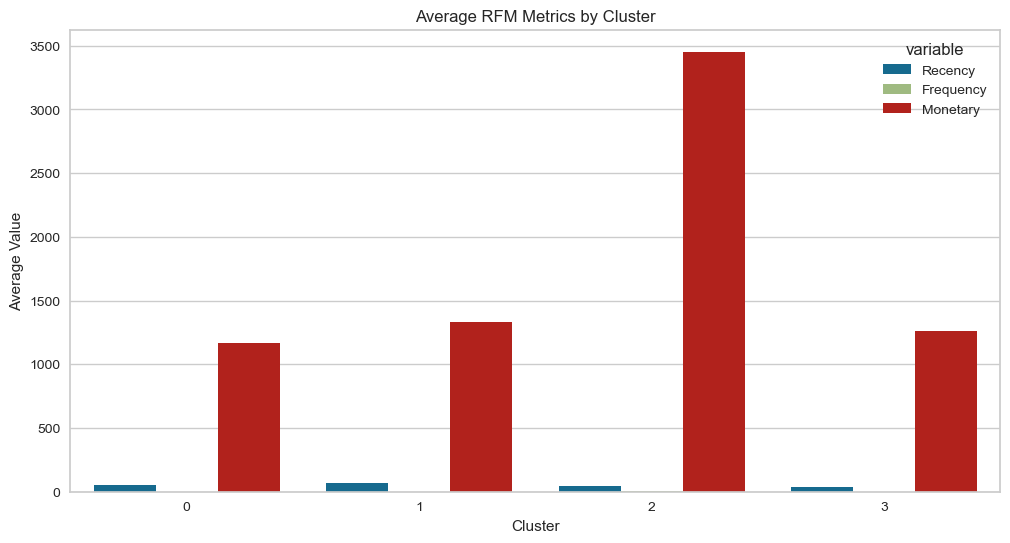

In [29]:
import seaborn as sns

# Prepare for plotting
melted = cluster_summary.melt(id_vars='Cluster', value_vars=['Recency', 'Frequency', 'Monetary'])

plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='Cluster', y='value', hue='variable')
plt.title("Average RFM Metrics by Cluster")
plt.ylabel("Average Value")
plt.show()

In [30]:
# View all unique RFM-based segments
print(rfm['Segment'].unique())

['Best Customers' 'Loyal Customers' 'At Risk' 'Churned']


In [31]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment,Cluster
0,C1010011,25,2,5106.0,4,2,4,424,10,Best Customers,2
1,C1010012,68,1,1499.0,2,1,4,214,7,Loyal Customers,1
2,C1010014,75,2,1455.0,1,2,4,124,7,Loyal Customers,2
3,C1010018,36,1,30.0,4,1,1,411,6,Loyal Customers,3
4,C1010028,53,1,557.0,3,1,3,313,7,Loyal Customers,0


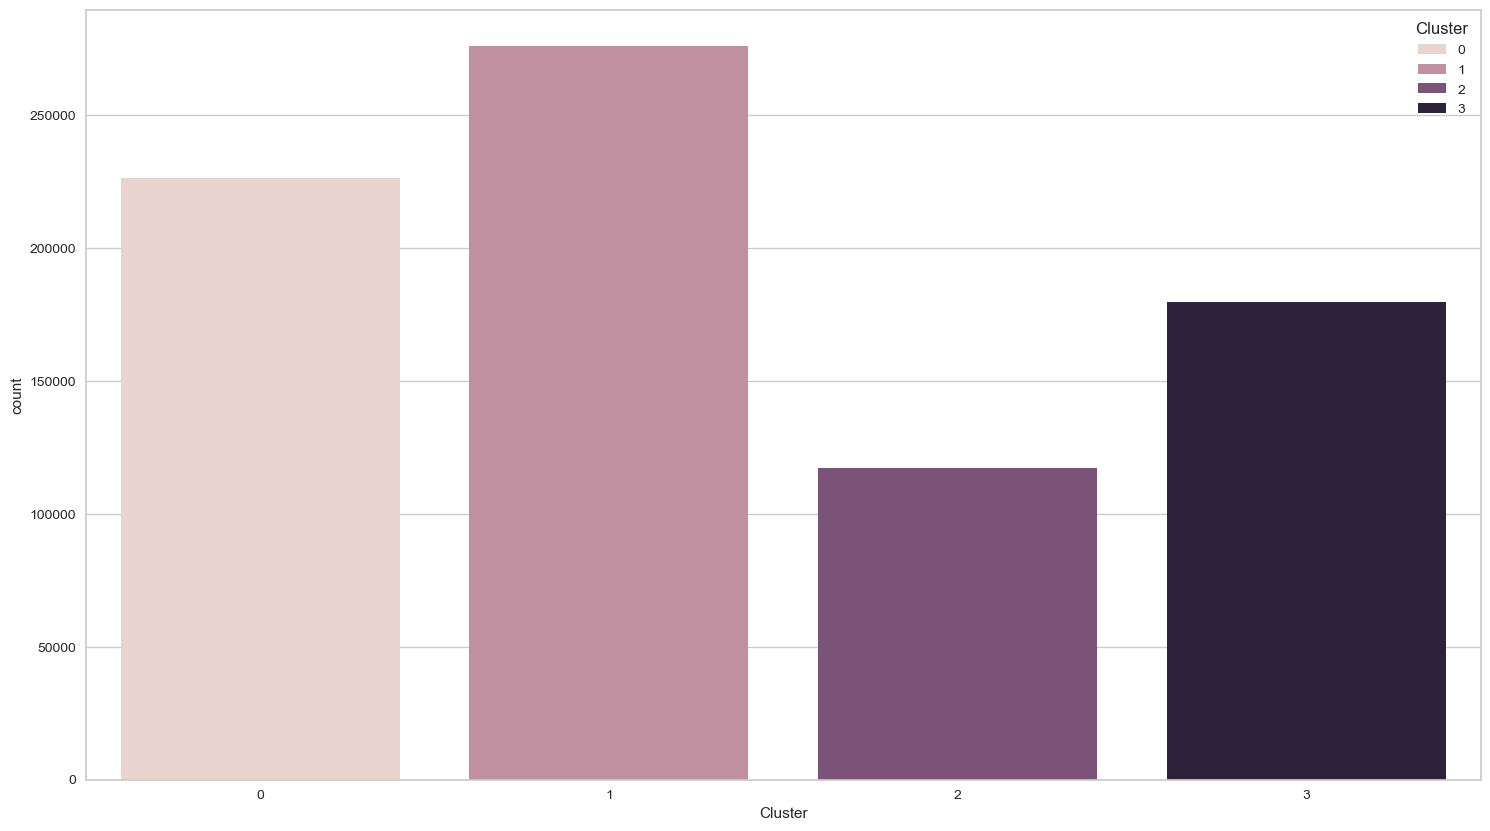

In [32]:

plt.figure(figsize = (18, 10))
sns.set_palette("pastel") #setting color and hue for differently colored bars, so we can observe the segments more easily.
sns.countplot(x=rfm['Cluster'], hue=rfm['Cluster'])

plt.show()


In [43]:
import os
os.makedirs("../output", exist_ok=True)

In [46]:
# Save RFM + Clustering results
rfm.to_csv("../output/rfm_segmented.csv", index=False)